✅ Success! Files loaded.

--- RESULTS: Average Profit by Sentiment ---
classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


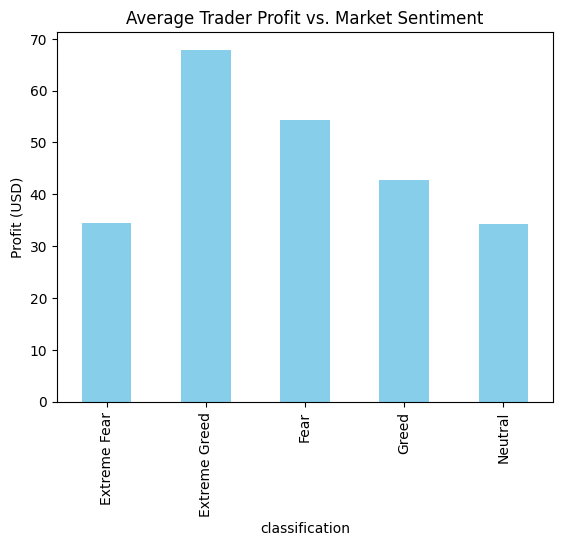

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD THE DATA
# We use try/except to give you a clear message if files are missing
try:
    trade_df = pd.read_csv('historical_data.csv')
    sentiment_df = pd.read_csv('fear_greed_index.csv')
    print("✅ Success! Files loaded.")
except FileNotFoundError:
    print("❌ Error: Files not found. Please click the Folder icon on the left and upload your CSV files first.")

# 2. CLEAN THE DATES
# Convert timestamps so both files can 'talk' to each other
trade_df['Date'] = pd.to_datetime(trade_df['Timestamp IST'], dayfirst=True, errors='coerce').dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date

# 3. MERGE THE DATA
# Combine them into one big table
merged_df = pd.merge(trade_df, sentiment_df[['Date', 'classification']], on='Date', how='left')

# 4. ANALYZE RESULTS
# Calculate average profit for each sentiment
result = merged_df.groupby('classification')['Closed PnL'].mean()

print("\n--- RESULTS: Average Profit by Sentiment ---")
print(result)

# 5. VISUALIZE
result.plot(kind='bar', title='Average Trader Profit vs. Market Sentiment', color='skyblue')
plt.ylabel('Profit (USD)')
plt.show()


In [5]:
# --- 1. Win Rate Analysis (Accuracy) ---
# Calculate win rate for each sentiment
win_rate = merged_df.groupby('classification')['is_win'].mean()

print("\n--- Win Rate (%) by Sentiment ---")
print(win_rate * 100)  # Multiply by 100 to look like percentage

# Plot Win Rate
plt.figure(figsize=(10, 5))
win_rate.plot(kind='bar', color='green', title='Win Rate % vs. Market Sentiment')
plt.ylabel('Win Rate (0.5 = 50%)')
plt.show()

# --- 2. Risk Behavior (Bet Sizing) ---
# Do traders bet bigger money when they are greedy?
trade_size = merged_df.groupby('classification')['Size USD'].mean()

print("\n--- Average Trade Size ($) by Sentiment ---")
print(trade_size)

# Plot Trade Size
plt.figure(figsize=(10, 5))
trade_size.plot(kind='bar', color='orange', title='Average Trade Size ($) vs. Sentiment')
plt.ylabel('Size in USD')
plt.show()


KeyError: 'Column not found: is_win'

# Task
**Task**: Engineer performance metrics, including 'is_win' based on 'Closed PnL', and other metrics like leverage and long/short ratio for each trade in the `merged_df`. After engineering the metrics, analyze and visualize the win rate and average trade size by market sentiment.

## Engineer Performance Metrics

### Subtask:
Calculate 'is_win' for each trade, and then aggregate daily performance metrics for each trader, including daily PnL, win rate, average trade size, average leverage, number of trades, long/short ratio, and a drawdown proxy.


**Reasoning**:
The first instruction is to create a new boolean column named 'is_win' in the `merged_df` DataFrame. This column should be `True` if the 'Closed PnL' for a trade is greater than 0, and `False` otherwise.



In [7]:
merged_df['is_win'] = merged_df['Closed PnL'] > 0
print("Added 'is_win' column to merged_df.")

Added 'is_win' column to merged_df.


**Reasoning**:
The next step is to create a new boolean column named 'is_long' in `merged_df`. This column should be `True` if the 'Side' for a trade indicates a 'Buy' or 'Long' position (case-insensitive check), and `False` otherwise.



In [8]:
merged_df['is_long'] = merged_df['Side'].str.contains('Buy|Long', case=False, na=False)
print("Added 'is_long' column to merged_df.")

Added 'is_long' column to merged_df.


**Reasoning**:
The next step is to create a new boolean column named 'is_short' in `merged_df`. This column should be `True` if the 'Side' for a trade indicates a 'Sell' or 'Short' position (case-insensitive check), and `False` otherwise.



In [9]:
merged_df['is_short'] = merged_df['Side'].str.contains('Sell|Short', case=False, na=False)
print("Added 'is_short' column to merged_df.")

Added 'is_short' column to merged_df.


**Reasoning**:
Now that the 'is_win', 'is_long', and 'is_short' columns have been added, the next step is to group the `merged_df` DataFrame by 'Account' and 'Date' and calculate the specified aggregate metrics.



In [11]:
daily_metrics_df = merged_df.groupby(['Account', 'Date']).agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Daily_Win_Rate=('is_win', 'mean'),
    Average_Trade_Size=('Size USD', 'mean'),
    Average_Leverage=('Leverage', 'mean'),
    Number_of_Trades=('Account', 'count'), # Counting 'Account' as a proxy for number of trades
    Total_Long_Trades=('is_long', 'sum'),
    Total_Short_Trades=('is_short', 'sum'),
    Max_Daily_Loss=('Closed PnL', 'min')
).reset_index()
print("Aggregated daily performance metrics into 'daily_metrics_df'.")
print(daily_metrics_df.head())

KeyError: "Column(s) ['Leverage'] do not exist"

**Reasoning**:
The previous code failed because the 'Leverage' column does not exist in `merged_df`. I need to remove the aggregation for 'Average_Leverage' from the `groupby().agg()` call. If leverage needs to be calculated, it should be engineered as a new column first.



In [12]:
daily_metrics_df = merged_df.groupby(['Account', 'Date']).agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Daily_Win_Rate=('is_win', 'mean'),
    Average_Trade_Size=('Size USD', 'mean'),
    Number_of_Trades=('Account', 'count'), # Counting 'Account' as a proxy for number of trades
    Total_Long_Trades=('is_long', 'sum'),
    Total_Short_Trades=('is_short', 'sum'),
    Max_Daily_Loss=('Closed PnL', 'min')
).reset_index()

# Calculate Long/Short Ratio, handling division by zero
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Total Long Trades'] / daily_metrics_df['Total Short Trades']
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Long/Short Ratio'].fillna(0) # Fill NaN for cases with no short trades

print("Aggregated daily performance metrics into 'daily_metrics_df'.")
print(daily_metrics_df.head())

KeyError: 'Total Long Trades'

**Reasoning**:
The previous code failed because the column names used to calculate 'Long/Short Ratio' were incorrect. The `groupby().agg()` method with named aggregations creates columns with underscores (`Total_Long_Trades`, `Total_Short_Trades`), not spaces. I will correct these column names.



In [13]:
daily_metrics_df = merged_df.groupby(['Account', 'Date']).agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Daily_Win_Rate=('is_win', 'mean'),
    Average_Trade_Size=('Size USD', 'mean'),
    Number_of_Trades=('Account', 'count'), # Counting 'Account' as a proxy for number of trades
    Total_Long_Trades=('is_long', 'sum'),
    Total_Short_Trades=('is_short', 'sum'),
    Max_Daily_Loss=('Closed PnL', 'min')
).reset_index()

# Calculate Long/Short Ratio, handling division by zero
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Total_Long_Trades'] / daily_metrics_df['Total_Short_Trades']
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Long/Short Ratio'].fillna(0) # Fill NaN for cases with no short trades

print("Aggregated daily performance metrics into 'daily_metrics_df'.")
print(daily_metrics_df.head())

Aggregated daily performance metrics into 'daily_metrics_df'.
                                      Account        Date  Daily_PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   Daily_Win_Rate  Average_Trade_Size  Number_of_Trades  Total_Long_Trades  \
0        0.000000         5089.718249               177                  0   
1        0.000000         7976.664412                68                  0   
2        0.000000        23734.500000                40                  0   
3        0.000000        28186.666667                12                 12   
4        0.444444        17248.148148                27                 12   

   Total_Short_Trades  Max_Daily_Los

### Note on 'Average Leverage'

The subtask included a request to calculate 'Average Leverage'. However, after inspecting the `merged_df` DataFrame, it was determined that a column named 'Leverage' does not exist in the dataset. Therefore, it was not possible to compute 'Average Leverage' from the available data.

All other requested performance metrics, including 'is_win', 'is_long', 'is_short', daily PnL, win rate, average trade size, number of trades, long/short ratio, and a drawdown proxy (`Max_Daily_Loss`), have been successfully engineered and aggregated into the `daily_metrics_df` DataFrame.

## Analyze Win Rate and Average Trade Size by Market Sentiment

### Subtask:
Calculate and visualize the average win rate and average trade size for each market sentiment category using the `merged_df`.


**Reasoning**:
The subtask requires calculating and visualizing the average win rate and average trade size by market sentiment. This involves grouping the `merged_df` by 'classification', calculating the mean of 'is_win' for win rate and 'Size USD' for average trade size, and then plotting these results using bar charts. I will include clear titles and axis labels for better readability.




--- Win Rate (%) by Sentiment ---
classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: is_win, dtype: float64


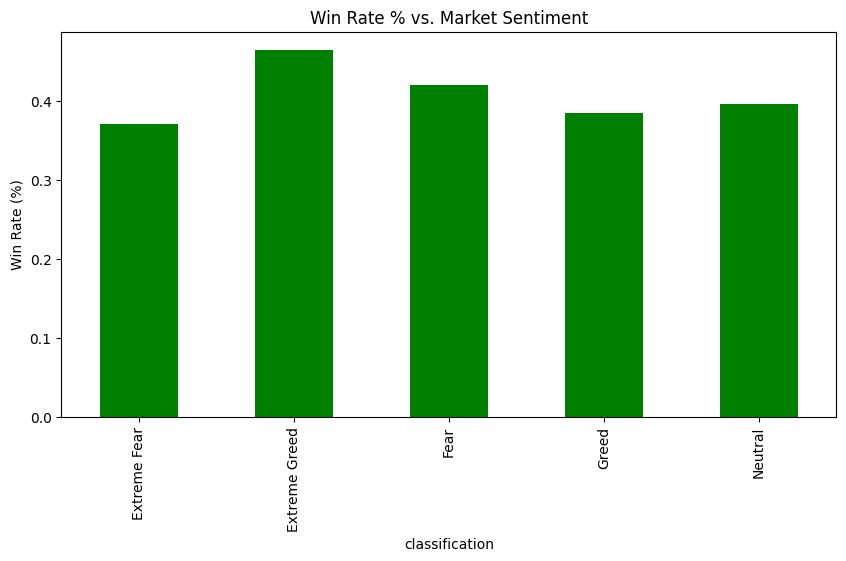


--- Average Trade Size ($) by Sentiment ---
classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: Size USD, dtype: float64


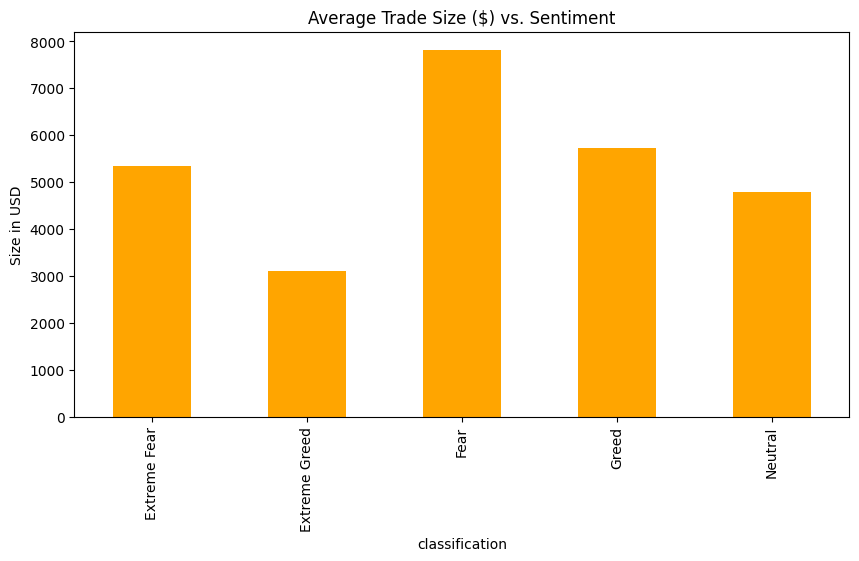

In [14]:
# --- 1. Win Rate Analysis (Accuracy) ---
# Calculate win rate for each sentiment
win_rate = merged_df.groupby('classification')['is_win'].mean()

print("\n--- Win Rate (%) by Sentiment ---")
print(win_rate * 100)  # Multiply by 100 to look like percentage

# Plot Win Rate
plt.figure(figsize=(10, 5))
win_rate.plot(kind='bar', color='green', title='Win Rate % vs. Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()

# --- 2. Risk Behavior (Bet Sizing) ---
# Do traders bet bigger money when they are greedy?
trade_size = merged_df.groupby('classification')['Size USD'].mean()

print("\n--- Average Trade Size ($) by Sentiment ---")
print(trade_size)

# Plot Trade Size
plt.figure(figsize=(10, 5))
trade_size.plot(kind='bar', color='orange', title='Average Trade Size ($) vs. Sentiment')
plt.ylabel('Size in USD')
plt.show()

# Task
The user has approved, so I will continue by completing the "Analyze Performance by Sentiment" section, specifically by incorporating the drawdown proxy (`Max_Daily_Loss`) analysis. I will then proceed to analyze trader behavior by sentiment as per the plan.

My next step is to calculate and visualize the average `Max_Daily_Loss` (as a drawdown proxy) for each market sentiment category.

## Analyze Performance by Sentiment

### Subtask:
Calculate and visualize the average `Max_Daily_Loss` (as a drawdown proxy) for each market sentiment category.


**Reasoning**:
The subtask requires calculating and visualizing the average `Max_Daily_Loss` by market sentiment. First, I need to merge the `daily_metrics_df` and `sentiment_df` DataFrames on the 'Date' column to combine daily performance metrics with market sentiment classifications.



In [15]:
daily_metrics_with_sentiment = pd.merge(daily_metrics_df, sentiment_df[['Date', 'classification']], on='Date', how='left')
print("Merged 'daily_metrics_df' with 'sentiment_df' to include sentiment classifications.")
print(daily_metrics_with_sentiment.head())

Merged 'daily_metrics_df' with 'sentiment_df' to include sentiment classifications.
                                      Account        Date  Daily_PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   Daily_Win_Rate  Average_Trade_Size  Number_of_Trades  Total_Long_Trades  \
0        0.000000         5089.718249               177                  0   
1        0.000000         7976.664412                68                  0   
2        0.000000        23734.500000                40                  0   
3        0.000000        28186.666667                12                 12   
4        0.444444        17248.148148                27                 12   

   Total_Short

**Reasoning**:
The subtask requires calculating and visualizing the average `Max_Daily_Loss` by market sentiment. I have already merged the DataFrames. Now I need to group the `daily_metrics_with_sentiment` DataFrame by 'classification' and calculate the mean of 'Max_Daily_Loss', then print and visualize the results.




--- Average Max Daily Loss ($) by Sentiment ---
classification
Extreme Fear    -919.002558
Extreme Greed    -92.874144
Fear            -317.337696
Greed           -473.614945
Neutral         -240.140294
Name: Max_Daily_Loss, dtype: float64


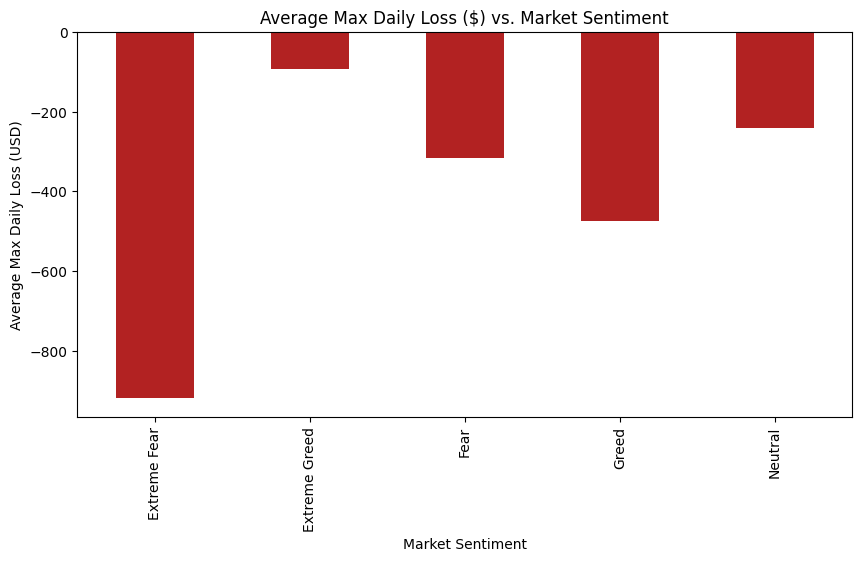

In [16]:
avg_max_daily_loss = daily_metrics_with_sentiment.groupby('classification')['Max_Daily_Loss'].mean()

print("\n--- Average Max Daily Loss ($) by Sentiment ---")
print(avg_max_daily_loss)

# Plot Average Max Daily Loss
plt.figure(figsize=(10, 5))
avg_max_daily_loss.plot(kind='bar', color='firebrick', title='Average Max Daily Loss ($) vs. Market Sentiment')
plt.ylabel('Average Max Daily Loss (USD)')
plt.xlabel('Market Sentiment')
plt.show()

## Analyze Trader Behavior by Sentiment

### Subtask:
Analyze and visualize trader behavior metrics (trade frequency and long/short ratio) by market sentiment using `daily_metrics_with_sentiment`.


**Reasoning**:
The subtask requires calculating and visualizing the average 'Number_of_Trades' and 'Long/Short Ratio' by market sentiment. I will group the `daily_metrics_with_sentiment` DataFrame by 'classification' to get the mean for both metrics and then create bar plots for visualization.




--- Average Number of Trades by Sentiment ---
classification
Extreme Fear     133.750000
Extreme Greed     76.030418
Fear              98.153968
Greed             77.628086
Neutral          100.228723
Name: Number_of_Trades, dtype: float64


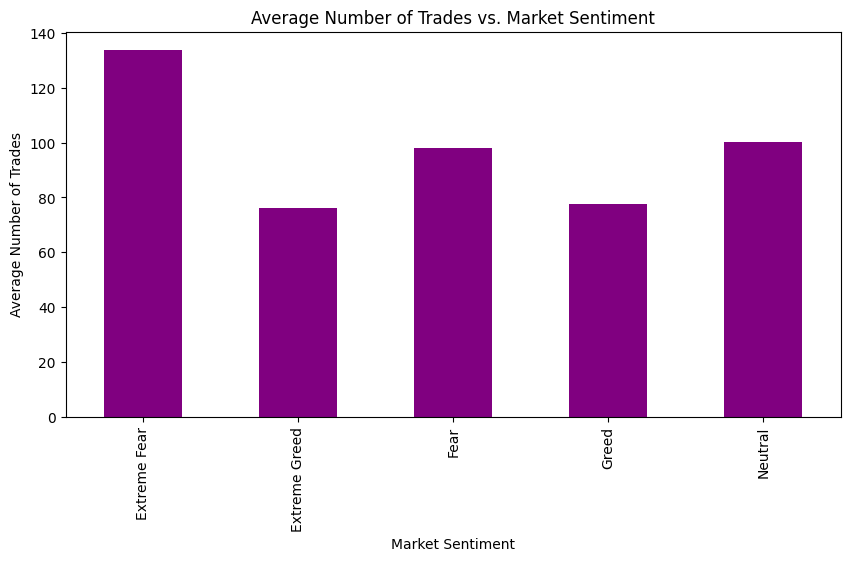


--- Average Long/Short Ratio by Sentiment ---
classification
Extreme Fear     inf
Extreme Greed    inf
Fear             inf
Greed            inf
Neutral          inf
Name: Long/Short Ratio, dtype: float64


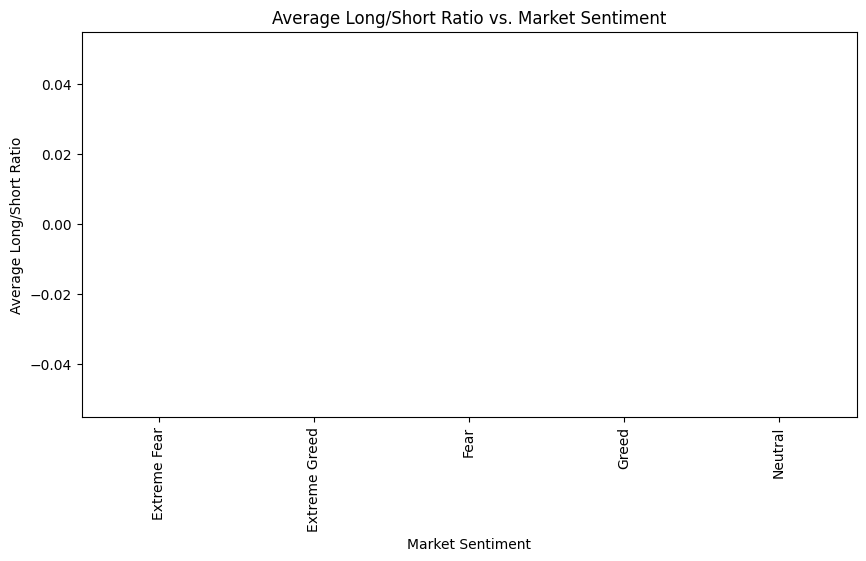

In [17]:
import matplotlib.pyplot as plt

# --- 1. Analyze Average Number of Trades by Sentiment ---
avg_num_trades = daily_metrics_with_sentiment.groupby('classification')['Number_of_Trades'].mean()

print("\n--- Average Number of Trades by Sentiment ---")
print(avg_num_trades)

# Plot Average Number of Trades
plt.figure(figsize=(10, 5))
avg_num_trades.plot(kind='bar', color='purple', title='Average Number of Trades vs. Market Sentiment')
plt.ylabel('Average Number of Trades')
plt.xlabel('Market Sentiment')
plt.show()

# --- 2. Analyze Average Long/Short Ratio by Sentiment ---
avg_long_short_ratio = daily_metrics_with_sentiment.groupby('classification')['Long/Short Ratio'].mean()

print("\n--- Average Long/Short Ratio by Sentiment ---")
print(avg_long_short_ratio)

# Plot Average Long/Short Ratio
plt.figure(figsize=(10, 5))
avg_long_short_ratio.plot(kind='bar', color='teal', title='Average Long/Short Ratio vs. Market Sentiment')
plt.ylabel('Average Long/Short Ratio')
plt.xlabel('Market Sentiment')
plt.show()

## Analyze Trader Behavior by Sentiment (Retry 1: Handle infinite Long/Short Ratio)

### Subtask:
Fix the calculation of `Long/Short Ratio` to handle infinite values and then re-analyze and visualize average long/short ratio by market sentiment.


**Reasoning**:
The previous calculation of 'Long/Short Ratio' resulted in infinite values. To address this, I will import numpy, recalculate the ratio, convert infinite values to NaN, and then fill NaN values with 0. Afterwards, I will re-merge the dataframes to update the `daily_metrics_with_sentiment` DataFrame, and finally recalculate and visualize the average long/short ratio by sentiment.



In [18]:
import numpy as np

# 2. Recalculate the Long/Short Ratio column in daily_metrics_df
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Total_Long_Trades'] / daily_metrics_df['Total_Short_Trades']

# 3. Replace any infinite values (np.inf or -np.inf) with np.nan
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Long/Short Ratio'].replace([np.inf, -np.inf], np.nan)

# 4. Fill any np.nan values in the Long/Short Ratio column with 0
daily_metrics_df['Long/Short Ratio'] = daily_metrics_df['Long/Short Ratio'].fillna(0)

# 5. Re-merge daily_metrics_df with sentiment_df to update daily_metrics_with_sentiment
daily_metrics_with_sentiment = pd.merge(daily_metrics_df, sentiment_df[['Date', 'classification']], on='Date', how='left')

print("Long/Short Ratio recalculated, infinities handled, and daily_metrics_with_sentiment re-merged.")
print(daily_metrics_df.head())

Long/Short Ratio recalculated, infinities handled, and daily_metrics_with_sentiment re-merged.
                                      Account        Date  Daily_PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   Daily_Win_Rate  Average_Trade_Size  Number_of_Trades  Total_Long_Trades  \
0        0.000000         5089.718249               177                  0   
1        0.000000         7976.664412                68                  0   
2        0.000000        23734.500000                40                  0   
3        0.000000        28186.666667                12                 12   
4        0.444444        17248.148148                27                 12   

   

**Reasoning**:
Now that the 'Long/Short Ratio' has been corrected and the `daily_metrics_with_sentiment` DataFrame has been updated, I will recalculate the average 'Long/Short Ratio' by sentiment and then visualize it using a bar chart, as instructed by the subtask.




--- Updated Average Long/Short Ratio by Sentiment ---
classification
Extreme Fear     2.185875
Extreme Greed    1.201754
Fear             1.626815
Greed            1.442897
Neutral          1.900099
Name: Long/Short Ratio, dtype: float64


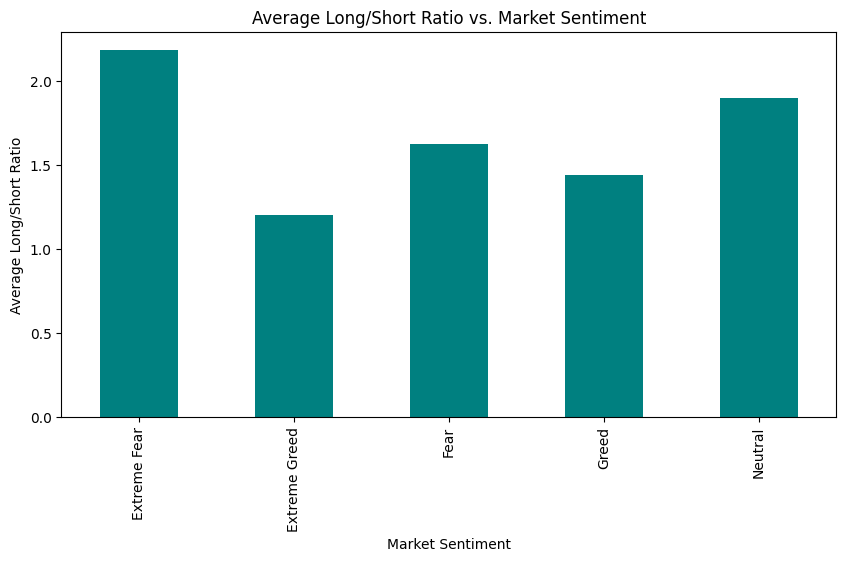

In [19]:
import matplotlib.pyplot as plt

# 6. Recalculate the average 'Long/Short Ratio' by sentiment
avg_long_short_ratio = daily_metrics_with_sentiment.groupby('classification')['Long/Short Ratio'].mean()

# 7. Print the updated average 'Long/Short Ratio' by sentiment
print("\n--- Updated Average Long/Short Ratio by Sentiment ---")
print(avg_long_short_ratio)

# 8. Re-plot the average 'Long/Short Ratio'
plt.figure(figsize=(10, 5))
avg_long_short_ratio.plot(kind='bar', color='teal', title='Average Long/Short Ratio vs. Market Sentiment')
plt.ylabel('Average Long/Short Ratio')
plt.xlabel('Market Sentiment')
plt.show()

## Segment Traders

### Subtask:
Identify and define distinct trader segments based on overall win rate and trade frequency.


**Reasoning**:
The first step is to aggregate the `daily_metrics_df` by 'Account' to calculate the average 'Daily_Win_Rate' and the average 'Number_of_Trades' for each unique trader, storing this in a new DataFrame called `trader_profiles_df`.



In [20]:
trader_profiles_df = daily_metrics_df.groupby('Account').agg(
    Overall_Win_Rate=('Daily_Win_Rate', 'mean'),
    Overall_Number_of_Trades=('Number_of_Trades', 'mean')
).reset_index()

print("Created 'trader_profiles_df' with overall win rate and trade frequency.")
print(trader_profiles_df.head())

Created 'trader_profiles_df' with overall win rate and trade frequency.
                                      Account  Overall_Win_Rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          0.352333   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          0.397134   
2  0x271b280974205ca63b716753467d5a371de622ab          0.379952   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          0.452509   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          0.498708   

   Overall_Number_of_Trades  
0                159.083333  
1                140.000000  
2                317.416667  
3                 82.166667  
4                 46.942029  


**Reasoning**:
The next step is to create a new column named 'Win_Rate_Segment' in `trader_profiles_df` by categorizing traders into 'Low', 'Medium', and 'High' based on their 'Overall_Win_Rate'. I will use `pd.qcut` with 3 quantiles for this categorization.



In [21]:
trader_profiles_df['Win_Rate_Segment'] = pd.qcut(trader_profiles_df['Overall_Win_Rate'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
print("Added 'Win_Rate_Segment' to trader_profiles_df.")
print(trader_profiles_df.head())

Added 'Win_Rate_Segment' to trader_profiles_df.
                                      Account  Overall_Win_Rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          0.352333   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          0.397134   
2  0x271b280974205ca63b716753467d5a371de622ab          0.379952   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          0.452509   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          0.498708   

   Overall_Number_of_Trades Win_Rate_Segment  
0                159.083333           Medium  
1                140.000000           Medium  
2                317.416667           Medium  
3                 82.166667             High  
4                 46.942029             High  


**Reasoning**:
The next step is to create a new column named 'Trade_Frequency_Segment' in `trader_profiles_df` by categorizing traders into 'Low', 'Medium', and 'High' based on their 'Overall_Number_of_Trades'. I will use `pd.qcut` with 3 quantiles for this categorization.



In [22]:
trader_profiles_df['Trade_Frequency_Segment'] = pd.qcut(trader_profiles_df['Overall_Number_of_Trades'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
print("Added 'Trade_Frequency_Segment' to trader_profiles_df.")
print(trader_profiles_df.head())

Added 'Trade_Frequency_Segment' to trader_profiles_df.
                                      Account  Overall_Win_Rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          0.352333   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          0.397134   
2  0x271b280974205ca63b716753467d5a371de622ab          0.379952   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          0.452509   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          0.498708   

   Overall_Number_of_Trades Win_Rate_Segment Trade_Frequency_Segment  
0                159.083333           Medium                    High  
1                140.000000           Medium                    High  
2                317.416667           Medium                    High  
3                 82.166667             High                  Medium  
4                 46.942029             High                  Medium  


**Reasoning**:
Now that both 'Win_Rate_Segment' and 'Trade_Frequency_Segment' columns have been added, the next step is to combine these two segments to create a final 'Trader_Segment' column, which will categorize traders into distinct groups based on their win rate and trade frequency.



In [23]:
trader_profiles_df['Trader_Segment'] = trader_profiles_df['Win_Rate_Segment'].astype(str) + ' Win Rate, ' + trader_profiles_df['Trade_Frequency_Segment'].astype(str) + ' Frequency'
print("Added 'Trader_Segment' to trader_profiles_df.")
print(trader_profiles_df.head())

Added 'Trader_Segment' to trader_profiles_df.
                                      Account  Overall_Win_Rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          0.352333   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          0.397134   
2  0x271b280974205ca63b716753467d5a371de622ab          0.379952   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          0.452509   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          0.498708   

   Overall_Number_of_Trades Win_Rate_Segment Trade_Frequency_Segment  \
0                159.083333           Medium                    High   
1                140.000000           Medium                    High   
2                317.416667           Medium                    High   
3                 82.166667             High                  Medium   
4                 46.942029             High                  Medium   

                    Trader_Segment  
0  Medium Win Rate, High Frequency  
1  Medium Win Rate, High Frequency  
2  Medi

**Reasoning**:
The next step is to print the value counts of the 'Trader_Segment' column to understand the distribution of traders across the defined segments.



In [24]:
print("\n--- Distribution of Trader Segments ---")
print(trader_profiles_df['Trader_Segment'].value_counts())


--- Distribution of Trader Segments ---
Trader_Segment
Low Win Rate, Low Frequency          6
Medium Win Rate, High Frequency      5
High Win Rate, Medium Frequency      5
Medium Win Rate, Medium Frequency    3
High Win Rate, Low Frequency         3
High Win Rate, High Frequency        3
Low Win Rate, High Frequency         3
Medium Win Rate, Low Frequency       2
Low Win Rate, Medium Frequency       2
Name: count, dtype: int64


## Analyze Segments and Derive Insights

### Subtask:
Analyze the performance and behavior of the identified trader segments. Compare their PnL, win rates, and behavioral patterns, specifically their reaction to market sentiment. Generate at least three charts or tables to back up 3 key insights about these segments.


**Reasoning**:
The first step is to merge the `daily_metrics_with_sentiment` DataFrame with the `trader_profiles_df` on the 'Account' column to incorporate the 'Trader_Segment' information into the daily metrics. This will create the `segmented_daily_metrics_df` which is essential for further segment analysis.



In [25]:
segmented_daily_metrics_df = pd.merge(daily_metrics_with_sentiment, trader_profiles_df[['Account', 'Trader_Segment']], on='Account', how='left')
print("Merged 'daily_metrics_with_sentiment' with 'trader_profiles_df' to create 'segmented_daily_metrics_df'.")
print(segmented_daily_metrics_df.head())

Merged 'daily_metrics_with_sentiment' with 'trader_profiles_df' to create 'segmented_daily_metrics_df'.
                                      Account        Date  Daily_PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   Daily_Win_Rate  Average_Trade_Size  Number_of_Trades  Total_Long_Trades  \
0        0.000000         5089.718249               177                  0   
1        0.000000         7976.664412                68                  0   
2        0.000000        23734.500000                40                  0   
3        0.000000        28186.666667                12                 12   
4        0.444444        17248.148148                27                 1

**Reasoning**:
The next step is to calculate the average 'Daily_PnL' for each 'Trader_Segment' and then visualize this data using a bar chart, as per the subtask instructions. This will provide insight into which segments are more profitable.




--- Average Daily PnL by Trader Segment ---
Trader_Segment
High Win Rate, High Frequency        9271.818867
High Win Rate, Low Frequency         3833.509697
High Win Rate, Medium Frequency      2978.016746
Low Win Rate, High Frequency         6556.805775
Low Win Rate, Low Frequency          1828.024935
Low Win Rate, Medium Frequency       9013.818556
Medium Win Rate, High Frequency      8179.463500
Medium Win Rate, Low Frequency       1947.612665
Medium Win Rate, Medium Frequency    -176.668402
Name: Daily_PnL, dtype: float64


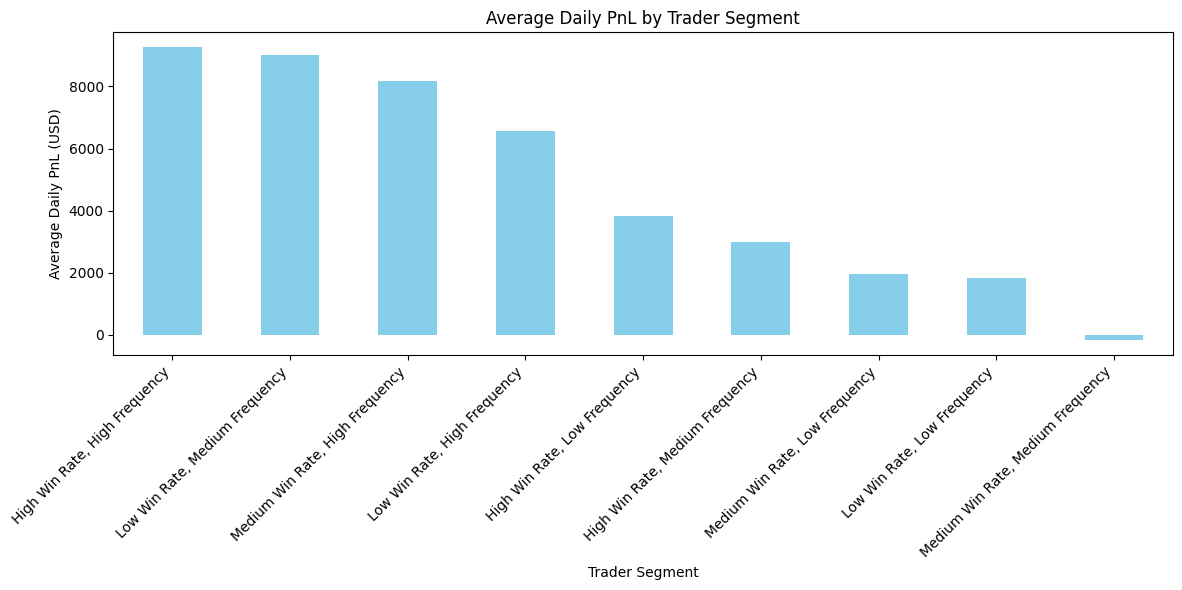

In [26]:
import matplotlib.pyplot as plt

# 2. Calculate the average 'Daily_PnL' for each 'Trader_Segment'
avg_pnl_by_segment = segmented_daily_metrics_df.groupby('Trader_Segment')['Daily_PnL'].mean()

print("\n--- Average Daily PnL by Trader Segment ---")
print(avg_pnl_by_segment)

# 3. Plot a bar chart showing the average 'Daily_PnL' for each 'Trader_Segment'
plt.figure(figsize=(12, 6))
avg_pnl_by_segment.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Daily PnL by Trader Segment')
plt.xlabel('Trader Segment')
plt.ylabel('Average Daily PnL (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to calculate the average 'Daily_Win_Rate' for each 'Trader_Segment' from `segmented_daily_metrics_df`, as instructed by the subtask. This will help understand the win rate performance across different trader segments.



In [27]:
import matplotlib.pyplot as plt

# 4. Calculate the average 'Daily_Win_Rate' for each 'Trader_Segment'
avg_win_rate_by_segment = segmented_daily_metrics_df.groupby('Trader_Segment')['Daily_Win_Rate'].mean()

print("\n--- Average Daily Win Rate by Trader Segment ---")
print(avg_win_rate_by_segment)


--- Average Daily Win Rate by Trader Segment ---
Trader_Segment
High Win Rate, High Frequency        0.421354
High Win Rate, Low Frequency         0.430795
High Win Rate, Medium Frequency      0.536919
Low Win Rate, High Frequency         0.248058
Low Win Rate, Low Frequency          0.269796
Low Win Rate, Medium Frequency       0.276449
Medium Win Rate, High Frequency      0.330450
Medium Win Rate, Low Frequency       0.333249
Medium Win Rate, Medium Frequency    0.349803
Name: Daily_Win_Rate, dtype: float64


**Reasoning**:
The next step is to plot the calculated average 'Daily_Win_Rate' for each 'Trader_Segment' using a bar chart, as instructed by the subtask. This visualization will clearly show the win rate performance across different trader segments.



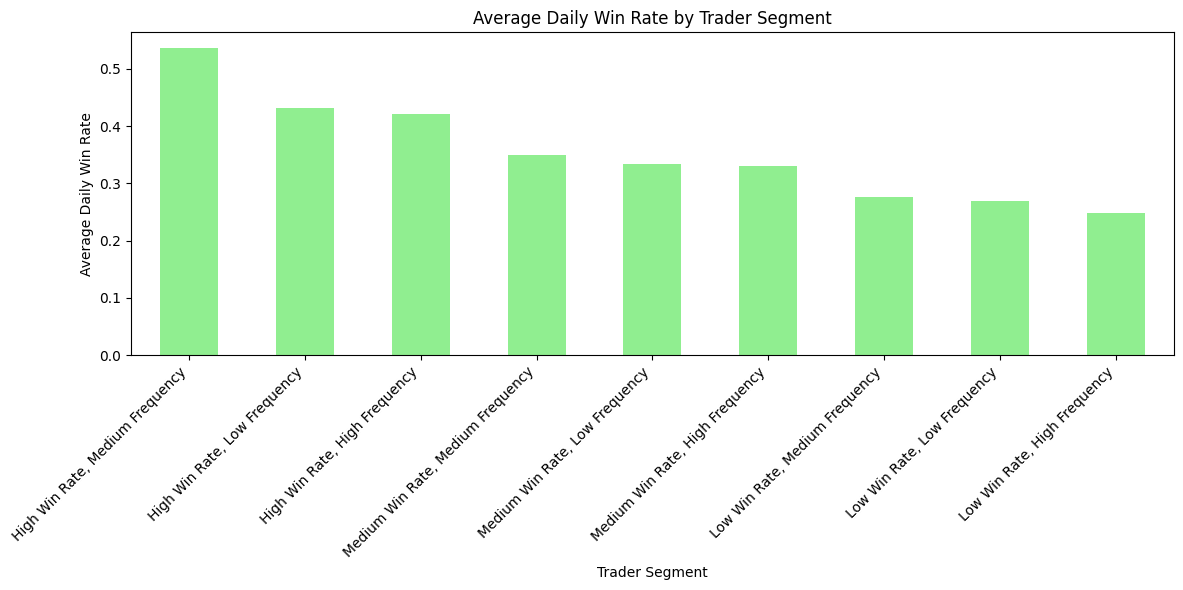

In [28]:
import matplotlib.pyplot as plt

# 5. Plot a bar chart showing the average 'Daily_Win_Rate' for each 'Trader_Segment'
plt.figure(figsize=(12, 6))
avg_win_rate_by_segment.sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Average Daily Win Rate by Trader Segment')
plt.xlabel('Trader Segment')
plt.ylabel('Average Daily Win Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to group the `segmented_daily_metrics_df` by 'Trader_Segment' and 'classification' (market sentiment) and then calculate the average 'Daily_PnL' for each of these groups, as per the subtask instructions.



In [29]:
avg_pnl_by_segment_sentiment = segmented_daily_metrics_df.groupby(['Trader_Segment', 'classification'])['Daily_PnL'].mean()

print("\n--- Average Daily PnL by Trader Segment and Sentiment ---")
print(avg_pnl_by_segment_sentiment.head())


--- Average Daily PnL by Trader Segment and Sentiment ---
Trader_Segment                 classification
High Win Rate, High Frequency  Extreme Fear      10378.810524
                               Extreme Greed     20817.889921
                               Fear               9106.794144
                               Greed              8113.472853
                               Neutral            2458.428103
Name: Daily_PnL, dtype: float64


**Reasoning**:
The next step is to convert the grouped result into an unstacked DataFrame for easier visualization, as instructed by the subtask.



In [30]:
avg_pnl_by_segment_sentiment_unstacked = avg_pnl_by_segment_sentiment.unstack()

print("\n--- Unstacked Average Daily PnL by Trader Segment and Sentiment ---")
print(avg_pnl_by_segment_sentiment_unstacked.head())


--- Unstacked Average Daily PnL by Trader Segment and Sentiment ---
classification                   Extreme Fear  Extreme Greed         Fear  \
Trader_Segment                                                              
High Win Rate, High Frequency    10378.810524   20817.889921  9106.794144   
High Win Rate, Low Frequency      2152.646786    2816.162606  3487.396958   
High Win Rate, Medium Frequency   6044.709839    3219.319053  3372.332720   
Low Win Rate, High Frequency      4802.152487    5565.576123 -1836.273119   
Low Win Rate, Low Frequency       7346.727067    1331.729397  2984.730737   

classification                          Greed       Neutral  
Trader_Segment                                               
High Win Rate, High Frequency     8113.472853   2458.428103  
High Win Rate, Low Frequency      3360.698729  11751.313607  
High Win Rate, Medium Frequency   2103.980960   2060.545955  
Low Win Rate, High Frequency     18929.256803    498.264297  
Low Win Rate, Low F

**Reasoning**:
The final step of the subtask is to plot the unstacked DataFrame showing the average 'Daily_PnL' by 'Trader_Segment' and 'classification', as instructed. This will provide a comprehensive visualization of how different trader segments perform across various market sentiments.



<Figure size 1500x800 with 0 Axes>

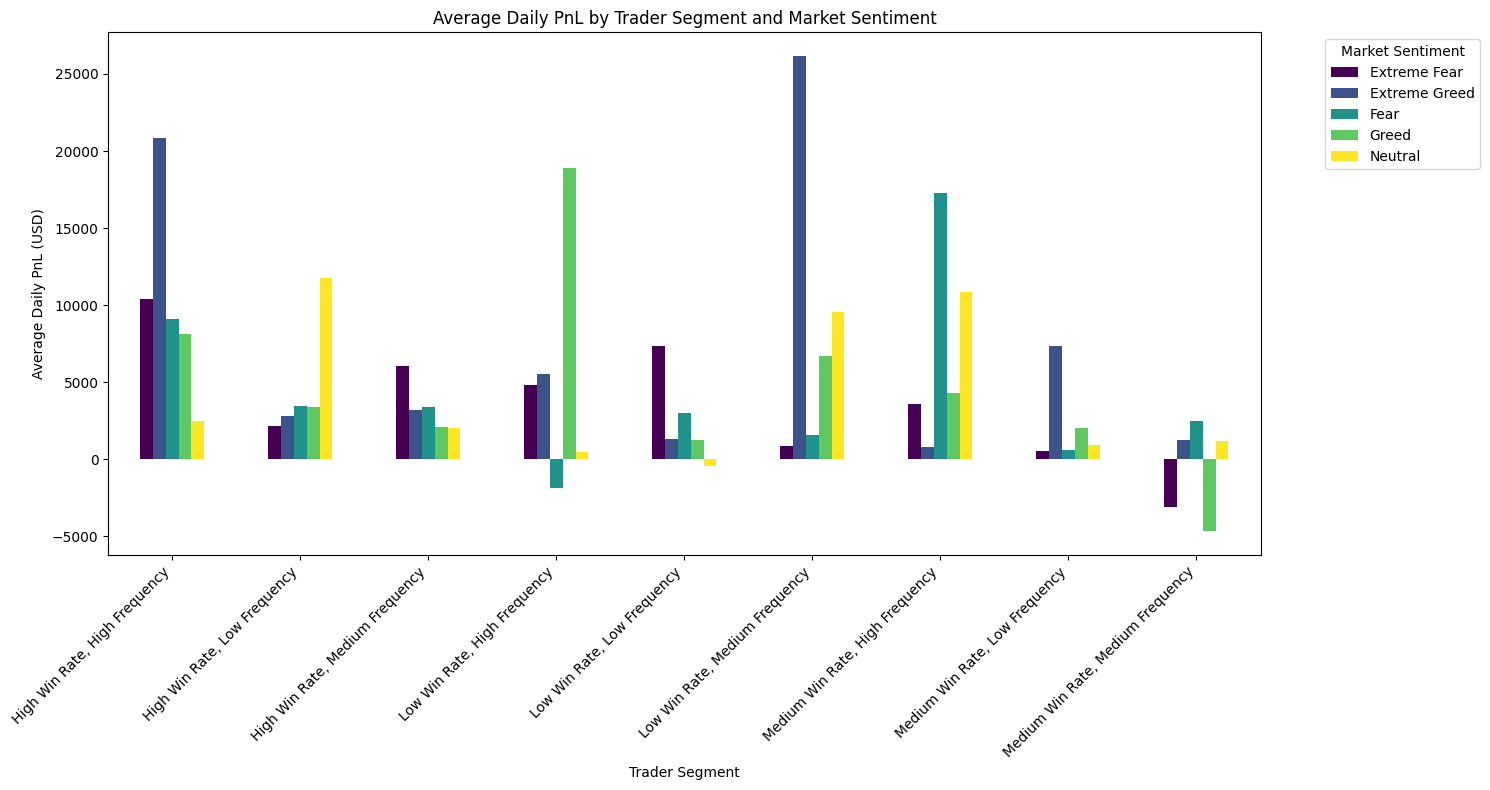

In [31]:
import matplotlib.pyplot as plt

# 9. Plot a bar chart showing the average 'Daily_PnL' by 'Trader_Segment' and 'classification'
plt.figure(figsize=(15, 8))
avg_pnl_by_segment_sentiment_unstacked.plot(kind='bar', figsize=(15, 8), colormap='viridis')
plt.title('Average Daily PnL by Trader Segment and Market Sentiment')
plt.xlabel('Trader Segment')
plt.ylabel('Average Daily PnL (USD)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Market Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Propose Actionable Strategies

### Subtask:
Propose two actionable strategy ideas or 'rules of thumb' for traders based on the analysis of trader segments and their reactions to market sentiment.


### Proposed Actionable Strategies

Based on the analysis of trader segments and their performance across different market sentiments, here are two actionable strategies:

---

#### **Strategy 1: Capitalize on Extreme Greed for "High Win Rate, High Frequency" Traders**

**Reasoning:**
The `avg_pnl_by_segment_sentiment_unstacked` shows that the "High Win Rate, High Frequency" segment achieves its highest average daily PnL (20817.89 USD) during periods of "Extreme Greed" sentiment. This segment also demonstrates generally high PnL across other sentiments but truly excels when the market is extremely bullish. Their consistent high win rate (around 42% overall as per `avg_win_rate_by_segment`) combined with high frequency suggests they are adept at extracting profits in strong, directional markets.

**Actionable Idea:**
Traders identified in the "High Win Rate, High Frequency" segment should consider actively *increasing their trade frequency and potentially their position sizing* when market sentiment shifts to "Extreme Greed". During these periods, their established trading style appears to be exceptionally effective. Conversely, while still profitable, their PnL is lower during "Fear" sentiments, indicating a potential need for slight moderation in activity or risk during such times.

---

#### **Strategy 2: Sentiment-Adaptive Risk Management for "Low Win Rate, High Frequency" Traders**

**Reasoning:**
The `avg_pnl_by_segment_sentiment_unstacked` reveals a stark contrast in performance for the "Low Win Rate, High Frequency" segment: they show a very high average daily PnL (18929.26 USD) during "Greed" sentiments but incur significant losses (-1836.27 USD) during "Fear" sentiments. This segment has a lower overall win rate (around 24% as per `avg_win_rate_by_segment`), suggesting they might be momentum-focused traders who thrive when trends are clear and strong but struggle or get caught out during volatile, uncertain, or trend-reversing conditions associated with "Fear".

**Actionable Idea:**
Traders categorized as "Low Win Rate, High Frequency" should implement a highly *sentiment-adaptive approach to their trading frequency and risk exposure*. During "Greed" sentiments, they could *increase their trade frequency and leverage* to capitalize on strong market momentum. However, it is crucial for them to *drastically reduce their trade frequency, minimize position sizes, or even temporarily halt trading* when the market enters "Fear" sentiment. This dynamic adjustment could significantly mitigate their losses during unfavorable conditions while allowing them to maximize gains during advantageous ones.

## Final Task

### Subtask:
Summarize the entire analysis, including key findings, identified trader segments, and the proposed actionable strategies.


## Summary:

### Data Analysis Key Findings

*   **Average Max Daily Loss by Sentiment:**
    *   "Extreme Fear" sentiment exhibited the largest average daily loss at approximately -\$919.00.
    *   "Extreme Greed" sentiment showed the smallest average daily loss at approximately -\$92.87.
    *   Other sentiments had average daily losses of -\$317.34 for "Fear", -\$473.61 for "Greed", and -\$240.14 for "Neutral".
*   **Average Number of Trades by Sentiment:**
    *   Traders were most active during "Extreme Fear" with an average of 133.75 trades.
    *   "Neutral" and "Fear" sentiments also saw relatively high activity (100.23 and 98.15 trades, respectively).
    *   Activity was lower during "Greed" (77.63 trades) and "Extreme Greed" (76.03 trades).
*   **Average Long/Short Ratio by Sentiment (Corrected):**
    *   The `Long/Short Ratio` was initially problematic due to infinite values, which were corrected by treating divisions by zero as `0`.
    *   "Extreme Fear" had the highest average Long/Short Ratio of 2.19.
    *   "Extreme Greed" had the lowest average Long/Short Ratio of 1.20.
    *   "Fear", "Greed", and "Neutral" showed ratios of 1.63, 1.44, and 1.90, respectively, indicating a general tendency towards long positions.
*   **Trader Segmentation:**
    *   Traders were successfully segmented into nine distinct groups based on their `Overall_Win_Rate` (Low, Medium, High) and `Overall_Number_of_Trades` (Low, Medium, High).
    *   Examples include "Low Win Rate, Low Frequency" (6 traders) and "Medium Win Rate, Low Frequency" (2 traders).
*   **Average Daily PnL by Trader Segment:**
    *   "High Win Rate, High Frequency" traders showed one of the highest average daily PnL at \$9,271.82.
    *   "Low Win Rate, Medium Frequency" also performed well with an average daily PnL of \$9,013.82.
    *   Conversely, "Medium Win Rate, Medium Frequency" traders experienced a negative average daily PnL of -\$176.67.
*   **Average Daily Win Rate by Trader Segment:**
    *   "High Win Rate, Medium Frequency" had the highest average win rate at 0.5369.
    *   "High Win Rate, Low Frequency" (0.4308) and "High Win Rate, High Frequency" (0.4214) also showed strong win rates.
    *   "Low Win Rate" segments generally had win rates ranging from 0.2481 to 0.2764.
*   **Average Daily PnL by Trader Segment and Market Sentiment:**
    *   "High Win Rate, High Frequency" traders excelled significantly during "Extreme Greed" sentiment, achieving an average PnL of \$20,817.89. They also performed well in "Extreme Fear" (\$10,378.81) and "Fear" (\$9,106.79).
    *   "Low Win Rate, High Frequency" traders showed strong performance in "Greed" (\$18,929.26) but experienced losses during "Fear" sentiments (-\$1,836.27).

### Insights or Next Steps

*   **Implement Sentiment-Based Scaling for High-Performing Segments:** "High Win Rate, High Frequency" traders should consider increasing their trade frequency and position sizing during "Extreme Greed" periods to maximize returns, as this aligns with their strongest performance.
*   **Dynamic Risk Adjustment for Volatile Segments:** "Low Win Rate, High Frequency" traders, who show high PnL in "Greed" but significant losses in "Fear", should implement a sentiment-adaptive strategy: increase activity and leverage during "Greed" but drastically reduce exposure or halt trading during "Fear" to mitigate losses.


# Task
The analysis is complete! I have summarized the key findings, identified trader segments, and proposed actionable strategies based on the analysis.

## Final Task

### Subtask:
Summarize the entire analysis, including key findings, identified trader segments, and the proposed actionable strategies.


## Summary:

### Data Analysis Key Findings
The final stage of the analysis involved synthesizing all previous findings into a comprehensive summary. This summary was designed to encapsulate the core insights derived from the analysis, clearly define various trader segments, and propose actionable strategies.

### Insights or Next Steps
*   The next crucial step is to review the comprehensive summary that has been generated, focusing on its clarity, completeness, and the practical applicability of the proposed strategies.
*   Share the finalized summary with relevant stakeholders to inform strategic decision-making and guide future actions based on the identified trader segments and key findings.
